# unknown point sampling

In [1]:
import pandas as pd
import numpy as np
import utils.augmentation as aug
import utils.plot as plot
from tqdm import tqdm
from sklearn.neighbors import KDTree

In [2]:
df = pd.read_csv('data/241202_Rockhead_Seoul_train(before_aumentation).csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12770 entries, 0 to 12769
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x              12770 non-null  float64
 1   y              12770 non-null  float64
 2   depth_start    12770 non-null  float64
 3   slope          12770 non-null  float64
 4   aspect         12770 non-null  float64
 5   DEM            12770 non-null  float64
 6   rock_type_1.0  12770 non-null  bool   
 7   rock_type_2.0  12770 non-null  bool   
 8   rock_type_3.0  12770 non-null  bool   
 9   neighbors      12770 non-null  int64  
 10  nn_bin         12770 non-null  float64
dtypes: bool(3), float64(7), int64(1)
memory usage: 835.7 KB


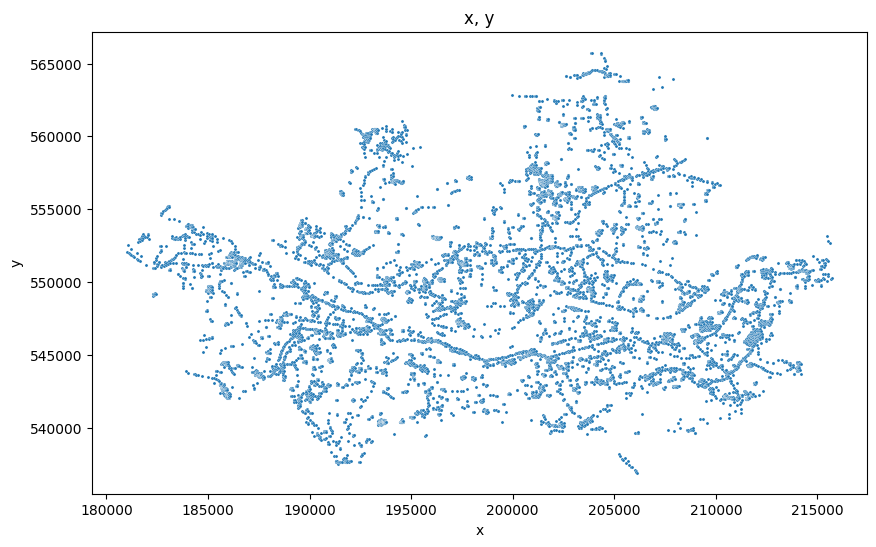

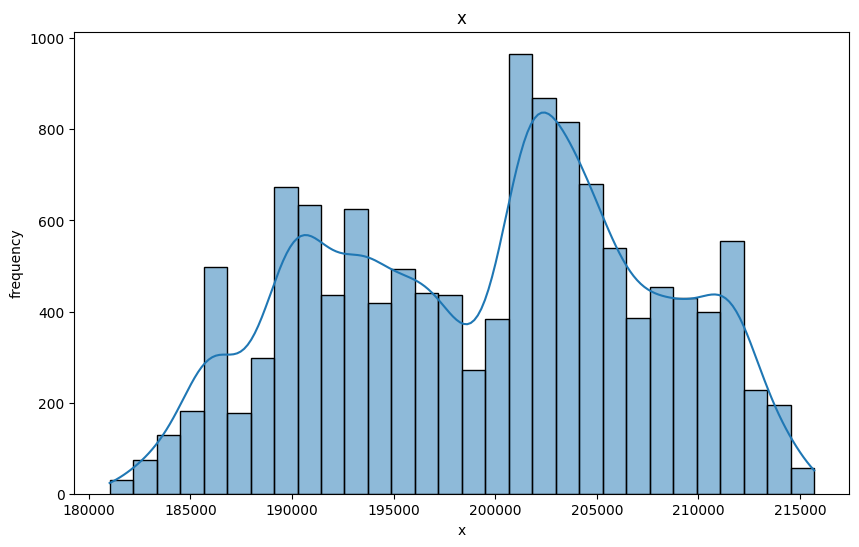

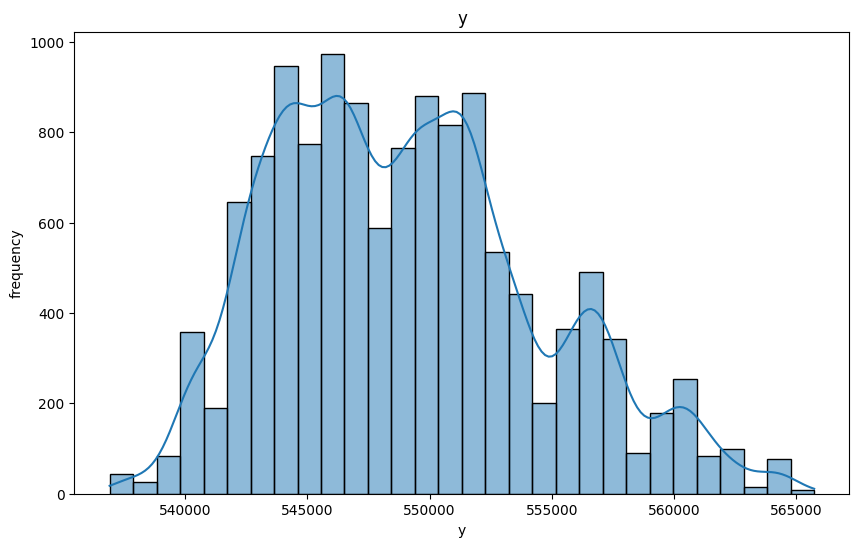

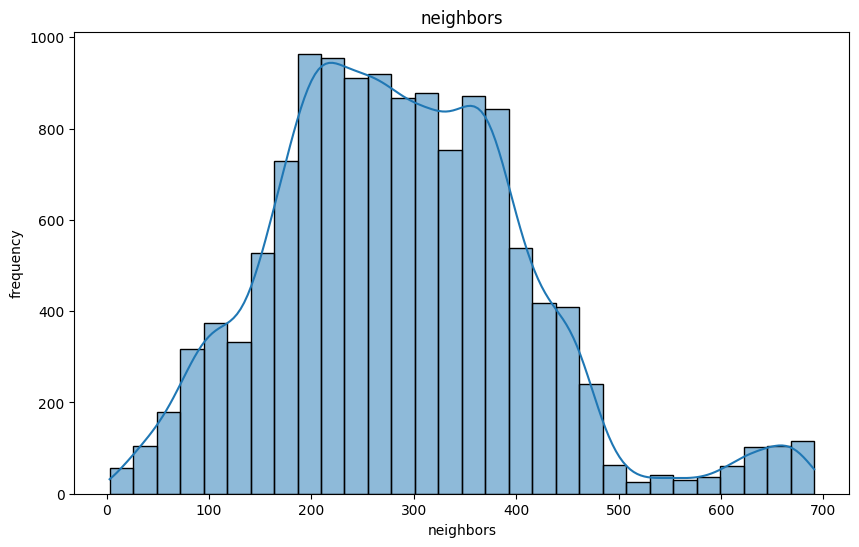

In [3]:
plot.scatter_relation(df, 'x', 'y', 5, 'x, y')
plot.distribution_histogram(df, 'x', 'x')
plot.distribution_histogram(df, 'y', 'y')
plot.distribution_histogram(df, 'neighbors', 'neighbors')

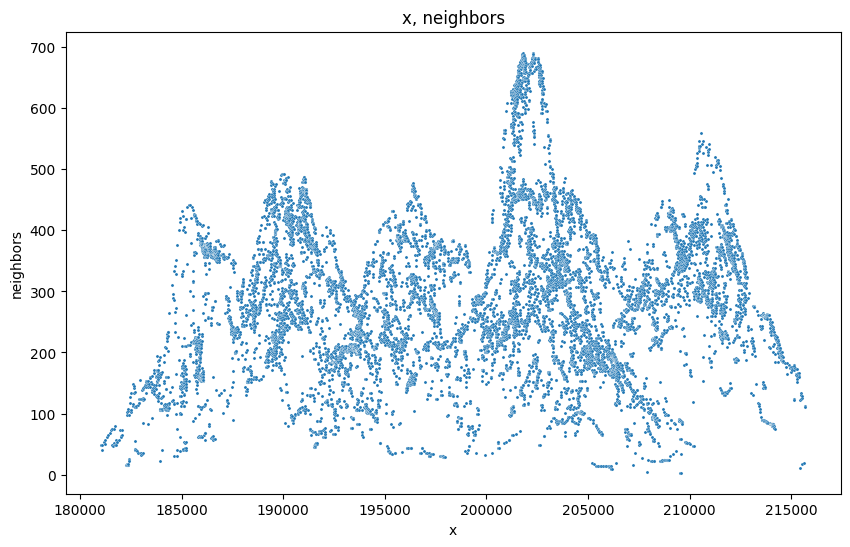

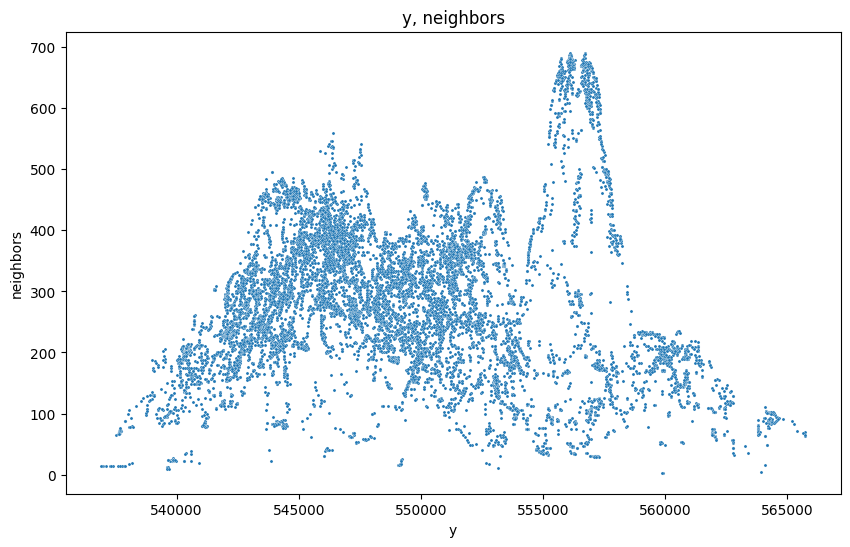

In [4]:
plot.scatter_relation(df, 'x', 'neighbors', 5, 'x, neighbors')
plot.scatter_relation(df, 'y', 'neighbors', 5, 'y, neighbors')

## IDW point selection

- 각 포인트의 일정 거리 내에 grid 간격의 포인트 생성
- 생성된 포인트에 대해 neighbors idw
- neighbors가 작은 값 지정된 간격으로 n개 선택

In [12]:
new_point = pd.DataFrame(columns=['x', 'y', 'neighbors'])

In [13]:
radius = 881
grid = 100
aug_per_point = 2 # maximum unknown count count
max_nn = 300 # maximum neighbor count per point
min_nn = 10 # maximum1 neighbor count per point
term = 1
select_term = 1 # select point term

df_center = df[df['neighbors'] < max_nn]
df_center = df_center[df_center['neighbors'] > min_nn]

df_center['num_points'] = aug_per_point-df_center['neighbors']/(max_nn//aug_per_point)

points = df_center[['x','y']].to_numpy()
num_points = df_center[['num_points']].to_numpy()

In [14]:
# create point's dataset
point_term = len(points)
location = df.loc[:,['x','y']].to_numpy()
values = df['neighbors'].to_numpy()
tree = KDTree(location, leaf_size=10000)

for i in tqdm(range(0, len(points), term)):
    # 1. generate circle grid
    grid_points = aug.generate_grid_points(points[i][0], points[i][1], radius, grid)

    # 2. IDW: unknown value generation
    indices, dists = tree.query_radius(grid_points, r=radius, return_distance=True)
    interpolated_values = aug.idw_interpolation(dists, indices, values, 1)
    
    # 3. select points
    selected_points, selected_values = aug.select_points_by_value(grid_points, interpolated_values, int(num_points[i][0]), select_term)
    
    # 4. data frame concat
    new_rows = pd.DataFrame({'x': selected_points[:, 0], 'y': selected_points[:, 1], 'neighbors': selected_values})
    new_point = pd.concat([new_point, new_rows], ignore_index=True)

new_point.to_csv('data/241202_Rockhead_Seoul_unknown_point.csv')

  0%|          | 0/7164 [00:00<?, ?it/s]C:\Users\mijin\AppData\Local\Temp\ipykernel_43824\3379508848.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_point = pd.concat([new_point, new_rows], ignore_index=True)
100%|██████████| 7164/7164 [02:11<00:00, 54.48it/s]


In [15]:
new_point['unknown'] = 1

df1 = df[['x', 'y', 'neighbors']]
df1['unknown'] = 0

result = pd.concat([df1, new_point], ignore_index=True)

length = len(result)
location = result.loc[:,['x','y']].to_numpy()
tree = KDTree(location, leaf_size=int(length*0.8))
neighbors = tree.query_radius(location, r=1789, count_only=True)
result['neighbors'] = neighbors

print(new_point.info())
print(result.info())

C:\Users\mijin\AppData\Local\Temp\ipykernel_43824\2864553148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['unknown'] = 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   x          1551 non-null   float64
 1   y          1551 non-null   float64
 2   neighbors  1551 non-null   float64
 3   unknown    1551 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 48.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14321 entries, 0 to 14320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   x          14321 non-null  float64
 1   y          14321 non-null  float64
 2   neighbors  14321 non-null  int64  
 3   unknown    14321 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 447.7 KB
None


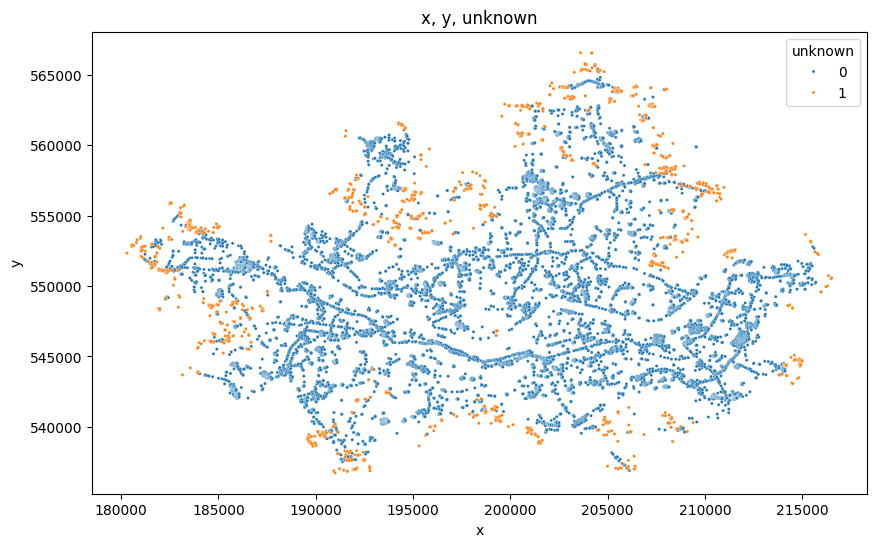

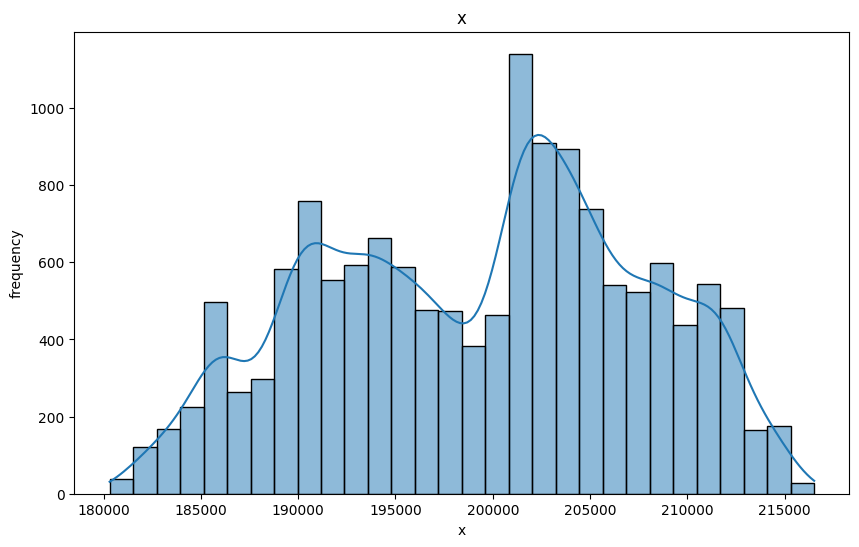

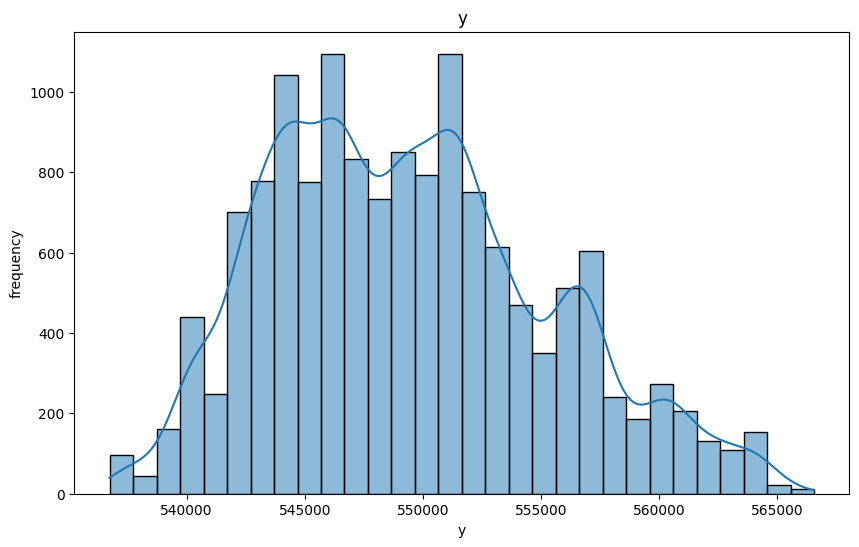

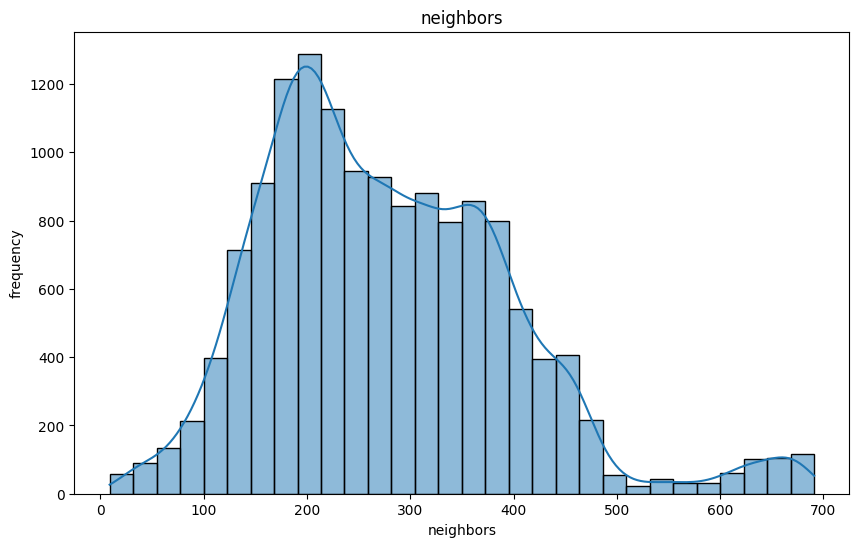

In [16]:
plot.scatter_relation(result, 'x', 'y', 5, 'x, y, unknown','unknown')
plot.distribution_histogram(result, 'x', 'x')
plot.distribution_histogram(result, 'y', 'y')
plot.distribution_histogram(result, 'neighbors', 'neighbors')